In [1]:
import inspect
import matplotlib
import matplotlib.pyplot as plt
import mrlattice.lattice as lat
from mrlattice.lattice.generate import SuperimposeLatticeArray
from IPython.display import HTML

FIXED_WIDTH = lat.configure.LatticeArrayScheme.FIXED_WIDTH_SCHEME
FIXED_NUMBER = lat.configure.LatticeArrayScheme.FIXED_NUMBER_SCHEME

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.3"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

## Summary

We present and explain the superposition routine for superimposing to LatticeArrays.


# Superimposing Two Mirrored Lattices

After we established the rules for the double cell tips in the previous notebook (0.1.3-1) we can now tackle the task of superimposing two lattices. In the early prototyping notebooks we had already developed a superposition routine. That routine is very powerfull and can deal with non double cell tips or even asymmetric tips. In the following we present a simplified version that only works for double cell tips. This version is much easier to explain and understand, so that we pay back our debt and explain how superimposing two LatticeArrays is done.


## New SuperimposeLatticeArray

In the presented code we extend the SuperimposeLatticeArray class, which has the restrictions for double cell tips from the last notebook implemented. We add the classmethod `superimpose` (with a helper method). We want `superimpose` to be a static method, as it shall work on arbitray input arrays and not be fixed to the `self.array`. However, we also need to access some methods of the class. This is why we use the classmethod decorator and pass the class `cls` as a first argument.

In order to see the new `superimpose` in action, we also extend the `generate_array` function and add a call to `superimpose`. We supply `self.array` and the output of `spatial_mirror` of `self.array`. We also pass `self._array` as the out argument so that the array gets modifed in place. This way of including `superimpose`, namely after the array is already generated, is slow because all time slices and regions need to be looped over twice. The first time this is the case when propagating the lattice and the second time when superimposing. In the next notebook we present a way to include the superposition routine inside of the propagation method.

Outputs are available below. For comparison we also plot the default LatticeArray with the same property values. Explanations follow the outputs.

In [6]:
class NewSuperimposeLatticeArray(SuperimposeLatticeArray):

    @classmethod
    def superimpose(cls, l, g, out=None):
        
        # throw error for mismatched len
        if (max_t:= len(l)) != len(g):
            raise lat.validate.LatticeGenerationError(
                "Superimposing lattices failed! Their temporal size differs:\n"
                f"{len(l)=}, {len(g)=}",
                prop="temporal size,"
            )
        
        if out is None:
            out = np.empty(max_t, dtype=object)

        # loop through all time slices in l and g
        for t in range(max_t):
            
            # the current time slices
            lt, gt = l[t], g[t]
                
            # manual iteration through lt, gt required
            # create the iterables through the regions
            l_iter, g_iter = iter(lt), iter(gt)
            # fetch first elements
            l_r, g_r = next(l_iter), next(g_iter)

            # output time slice
            o = [(((),),)]
            # offset leftover for mismatched regions
            l_offset, g_offset = 0, 0

            try:
                # fake iteration over lt, gt
                while True:
                    
                    # set current size
                    # leftovers of current regions or new regions' widths
                    l_size = l_offset if l_offset > 0 else l_r[-1] * l_r[1]
                    g_size = g_offset if g_offset > 0 else g_r[-1] * g_r[1]

                    # finer resolution prevails: min
                    r_m = (min(l_r[0], g_r[0]), min(l_r[1], g_r[1]))
                    
                    # regions share size
                    if l_size == g_size:
                        # append next region
                        cls._superimpose_step_spatial_extend(l_size, r_m, o)
                        # no offset, regions have same size
                        l_offset, g_offset = 0, 0
                        # advance iterables
                        l_r = next(l_iter)
                        g_r = next(g_iter)

                    elif l_size < g_size:
                        # append next region
                        cls._superimpose_step_spatial_extend(l_size, r_m, o)
                        # calculate covered region
                        g_offset = g_size - l_size
                        l_offset = 0
                        # advance iterable, g_r has leftover
                        l_r = next(l_iter)

                    # l_size > g_size
                    else:
                        # append next region
                        cls._superimpose_step_spatial_extend(g_size, r_m, o)
                        # calculate covered region
                        l_offset = l_size - g_size
                        g_offset = 0
                        # advance iterable, l_r has leftover
                        g_r = next(g_iter)

            except StopIteration as e:
                # will catch next([*]_iter) depletion

                # check same spatial width for both input arrays
                if g_offset or l_offset:
                    # if other than 0, there is leftover
                    raise lat.validate.LatticeGenerationError(
                        "Superimposing lattices failed! Their spatial size differs:\n"
                        f"l[{t}]={lt}\ng[{t}]={gt}",
                        prop="spatial size",
                    ) from e

            # append new time slice in o to out
            # discard first, empty region
            out[t] = tuple(o[0][1:])

        return out
    
    @classmethod
    def _superimpose_step_spatial_extend(cls, size, res, output):
        # this divison has no remainder for double cell tips
        # int division used to get int type
        num_coa = size // res[1]
        # add num_coa cells, change in place
        cls.spatial_extend(
            output,
            (((res[0], res[1], num_coa),),),
            out=output,
        )
    
    def generate_array(self, *args, **kwargs):
        super().generate_array(*args, **kwargs)
        
        self.superimpose(
            self.array,
            self.spatial_mirror(self.array),
            self._array,  # modify in place
        )

In [7]:
print(inspect.getsource(SuperimposeLatticeArray.spatial_extend))

    @staticmethod
    def spatial_extend(left, right, out=None) -> np.ndarray:
        """Append lattice array `right` to the spatial right of `left`.

        Args:
            left: Lattice array on the spatial left.
            right: Lattice array on the spatial right.
            out: Lattice array to save output.

        All arguments must have the same len and dtype. If the touching
        regions of `left` and `right` share resolution, they get merged.

        Returns:
            If `out` is given, change `out` in place and return `out`.
            Else return new lattice array.

        Raises:
            TypeError: If `out` doesn't have `dtype=object`.
            IndexError: If `left`, `right` or `out` don't have same len.
        """
        if out is None:
            out = np.empty(len(left), dtype=object)

        # take max, so that loop below throws error for mismatched len
        max_len = max(len(left), len(right), len(out))

        try:
            for t in 

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

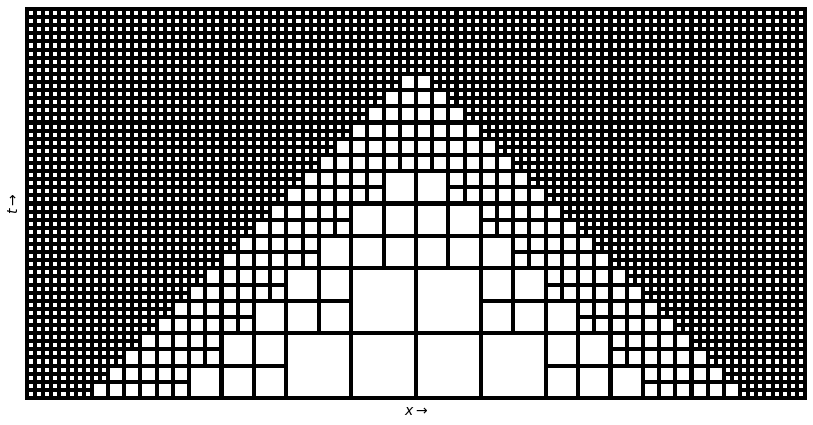

In [8]:
prop_dict = {
    "scheme": FIXED_WIDTH,
    "coarse_steps": 3,
    "borders_width": 10,
    "buffer": 3,    
}
LatticeArrayPlotWidget(lattice=NewSuperimposeLatticeArray(**prop_dict))

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

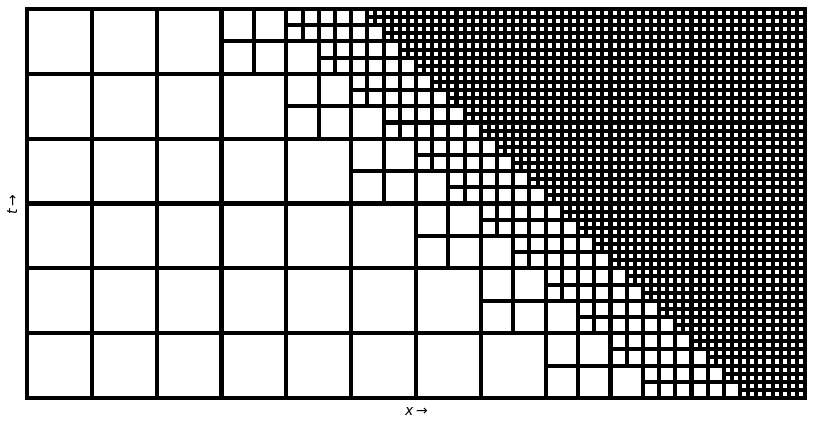

In [9]:
LatticeArrayPlotWidget(lattice=SuperimposeLatticeArray(**prop_dict))

## Superposition Routine

(Flowcharts are included below)

The `superimpose` function implements two loops. One over all time slices and one over the coarsening regions. The catch is, that while both inputs to superimpose must have the same number of time slices, they will not have the same number of cells per time slice. This requires to loop over the coarsening regions and bookkeep the position in the lattice when any of the input lattices' resolutions change. This translates to a simple for loop for the time slices but to a "fake loop" over the regions.

On entering `superimpose` we first make sure the input lattices have the same len, which is the number of time slices. Then we start the loop over the time slices. In this loop we create iterables for the coarsening regions which we will manually advance in the fake loop. For bookkeeping we introduce the offset varables, which will save the amount of space [finest units] that is left in either region, should one be narrower than the other.

The fake loop contains the actual superposition logic. We start with 0 offsets, so we calculate the sizes of the first regions of each input lattice. Then we choose the resolution of the region that is finer. We now need to calculate the number of cells we can append to our time slice with that resolution. We need to fill the size of whichever region is narrower. If the regions' sizes differ, we will get an offset for the wider region. This offset will become the new size of the wider region in the next iteration. After appending the cells and calculating the offset, we advance the iterator of the region that is now fully filled (or both if they share sizes). Calling `next()` on a depleted iterator will raise an `StopIteration` error. We then know, that we depleted all coarsening regions of the time slice of at least one input lattice. Checking, if both offsets are 0 is a simple way to make sure, that both input lattices share the same spatial width. Yes, there could be occasions where this check fails, i.e. when one lattice is consistently wider than the other and the overhanging cells are all of the same resolution that is different from the overlapping region. But instead of raising an exception in that case, we just cut off the overhang with this solution.

After leaving the fake loop, we set the temporary time slice as the output, modifying it in place. We also return the output, which is necessary if no `out` was given and we created a new lattice array.

For appending regions to an existing time slice we use the `spatial_extend` method instead of just concatinating lists with `+`. Its main purpose is to implicitly merge the region to append if it has the same resolution as the last region in the time slice to append to. This simplifies the lattice array by minimizing the number of regions. `spatial_extend` can also deal with multiple time slices, as long as all its args have the same number of time slices.

## Flowchart for `superimpose()`

In [10]:
display(HTML("imgs/flowcharts/superimpose_logic/superimpose_main.html"))

## Flowchart for the Fake Loop

In [11]:
display(HTML("imgs/flowcharts/superimpose_logic/superimpose_loop.html"))